# Tabulation of households by income group and household size
Using data from synthetic households for Plan Bay Area, what is the distribution of households by income group by household size?

In [298]:
import pandas as pd
from pandas_datareader import data as dt, wb

# CPI data

The PUMS seed sample is from 2007-2011 - we can use this to get to 2020 if need be.

In [299]:
datapool = {
    'CPIAUCSL': 'All Urban Consumers (CPI-U) U.S.',
    #'CUURA422SA0': 'All Urban Consumers (CPI-U) SF-OAK-HAY',
}

indicators_all = {}
for series, series_nme in datapool.items():
    data = dt.DataReader(series, "fred", start="1970-1-1")

    # renaming not necessary in master
    print("renaming field %s to %s" % (series, datapool[series]))
    indicators_all[series_nme] = data

renaming field CPIAUCSL to All Urban Consumers (CPI-U) U.S.


In [300]:
date_range = pd.date_range(start='2010',end='2021',freq='AS-DEC')

In [301]:
inflation_2011_2020 = pd.concat(indicators_all).stack().unstack([0,2]).dropna().loc['2020-12-01']/pd.concat(indicators_all).stack().unstack([0,2]).dropna().loc['2011-12-01']
inflation_2011_2020

All Urban Consumers (CPI-U) U.S.  CPIAUCSL    1.153206
dtype: float64

# Paths

In [234]:
SYNTH_POP_2020 = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2020_TransitRecovery_20220805_run182_modv01/synthetic_persons.csv'
SYNTH_HH_2020 = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2020_TransitRecovery_20220805_run182_modv01/synthetic_households.csv'

In [235]:
SYNTH_POP_2050 = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2050_PBA50PlusCrossing_20201125_run182/synthetic_persons.csv'
SYNTH_HH_2050 = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2050_PBA50PlusCrossing_20201125_run182/synthetic_households.csv'

In [7]:
SYNTH_POP_2035 = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2035_PBA50PlusCrossing_20201125_run182/synthetic_persons.csv'
SYNTH_HH_2035 = '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2035_PBA50PlusCrossing_20201125_run182/synthetic_households.csv'

# Load data

In [236]:
popul = pd.read_csv(SYNTH_POP_2035)
popul.columns

Index(['PUMA', 'TAZ', 'unique_hh_id', 'SERIALNO', 'SPORDER', 'PWGTP', 'AGEP',
       'COW', 'MIL', 'RELP', 'SCHG', 'SCHL', 'SEX', 'WKHP', 'WKW', 'ESR',
       'HISP', 'naicsp07', 'PINCP', 'POWPUMA', 'socp00', 'socp10', 'indp02',
       'indp07', 'occp02', 'occp10', 'occupation', 'employed', 'employ_status',
       'student_status', 'person_type'],
      dtype='object')

In [238]:
hh = pd.read_csv(SYNTH_HH_2035)
hh.columns

Index(['unique_hh_id', 'PUMA', 'TAZ', 'SERIALNO', 'ADJINC', 'WGTP', 'NP',
       'TYPE', 'BLD', 'HHT', 'HINCP', 'HUPAC', 'NPF', 'TEN', 'VEH',
       'hh_workers_from_esr', 'hh_income_2010', 'hh_income_2000'],
      dtype='object')

In [239]:
# drop group quarter households
hh = hh[hh.TYPE!=3]

In [ ]:
# do internal income adjustments

hh['hh_income_2011'] = hh.HINCP * hh.ADJINC/1e6
hh['hh_income_2010'] = hh['hh_income_2011'] / 1.03154279

hh['hh_income_2020'] = hh.hh_income_2011 * inflation_2011_2020.iloc[0]

In [241]:
hh[[ 'hh_income_2011','hh_income_2000','hh_income_2010', 'hh_income_2020']]

,hh_income_2011,hh_income_2000,hh_income_2010,hh_income_2020
0,240440.4840,184650.788466,233088.230882,277277.486104
1,155579.4597,119480.145644,150822.109570,179415.216428
2,212760.2000,163393.138941,206254.361974,245356.407613
3,271563.8079,208552.453071,263259.857499,313169.099973
4,145516.9800,111752.487659,141067.323053,167811.101228
...,...,...,...,...
3612690,11382.6707,8741.532933,11034.608366,13126.567807
3612691,19191.1212,14738.182199,18604.289988,22131.322285
3612692,0.0000,0.000000,0.000000,0.000000
3612693,13512.2910,10377.016711,13099.108569,15582.459400


## Discretize income into groups

In [242]:
inc_bins_2000 = [-40000, 30000, 60000, 100000, 1000000]
inc_labels_2000 = [*(f'hh_inc_{a/1000:02.0f}_{b/1000:02.0f}' for a,
                 b in zip(inc_bins_2000[:-1], inc_bins_2000[1:]))]
inc_labels_2000[0] =  f'hh_inc_%s'%str(int(inc_bins_2000[1]/1000))
inc_labels_2000[-1] =  f'hh_inc_%s_plus'%str(int(inc_bins_2000[-2]/1000))
#inc_labels_2000[-1] = '%sup'%str(int(inc_bins_2000[-2]))
inc_labels_2000

['hh_inc_30', 'hh_inc_30_60', 'hh_inc_60_100', 'hh_inc_100_plus']

In [245]:
inc_bins_2020 = [-40000, 50000, 100000, 170000, 1000000]
inc_labels_2020 = [*(f'hh_inc_{a/1000:02.0f}_{b/1000:02.0f}' for a,
                 b in zip(inc_bins_2020[:-1], inc_bins_2020[1:]))]
inc_labels_2020[0] =  f'hh_inc_%s'%str(int(inc_bins_2020[1]/1000))
inc_labels_2020[-1] =  f'hh_inc_%s_plus'%str(int(inc_bins_2020[-2]/1000))
#inc_labels_2020[-1] = '%sup'%str(int(inc_bins_2020[-2]))
inc_labels_2020

['hh_inc_50', 'hh_inc_50_100', 'hh_inc_100_170', 'hh_inc_170_plus']

In [247]:
hh["HHINC_CAT"] = pd.cut(hh.hh_income_2000, inc_bins_2000, labels=inc_labels_2000)
hh["HHINC_CAT"].value_counts()

hh_inc_100_plus    1117800
hh_inc_30           974092
hh_inc_30_60        725344
hh_inc_60_100       679974
Name: HHINC_CAT, dtype: int64

In [248]:
#hh["HHINC_CAT"] = pd.qcut(hh.HINCP, 4, labels=False).add(1)

## Discretize household size

In [250]:
hh.HHINC_CAT.value_counts()

hh_inc_100_plus    1117800
hh_inc_30           974092
hh_inc_30_60        725344
hh_inc_60_100       679974
Name: HHINC_CAT, dtype: int64

In [254]:
hh["HHSIZE_CAT"] = pd.cut(hh.NP, bins=pers_bins, labels=['hh_size_1', 'hh_size_2', 'hh_size_3', 'hh_size_4_plus'])

# Summaries

In [307]:
# 2-way distribution

summary_inc_by_size = hh.groupby(['HHINC_CAT','HHSIZE_CAT']).size().unstack(1)
summary_inc_by_size

HHSIZE_CAT,hh_size_1,hh_size_2,hh_size_3,hh_size_4_plus
HHINC_CAT,,,,
hh_inc_30,486744,263037,93614,130697
hh_inc_30_60,185930,249057,126420,163937
hh_inc_60_100,94117,239098,134465,212294
hh_inc_100_plus,63929,401837,231163,420871


/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_24533/846619160.py:4: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax = summary_inc_by_size.stack().groupby(level='HHINC_CAT').apply(


Text(0.5, 1.0, 'Household Size Distribution, by Income Group\nSource: output_2035_PBA50PlusCrossing_20201125_run182.csv')

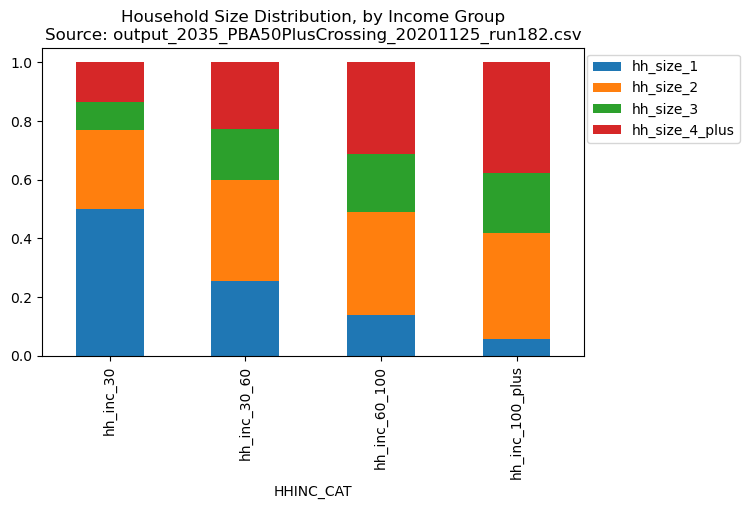

In [303]:
def pct(x): return x/x.sum()


ax = summary_inc_by_size.stack().groupby(level='HHINC_CAT').apply(
    pct).unstack('HHSIZE_CAT').plot(kind='bar', figsize=[7, 4], stacked=True)
ax.legend(loc=1, bbox_to_anchor=(1.3, 1))
ax.set_title(
    'Household Size Distribution, by Income Group\nSource: output_2035_PBA50PlusCrossing_20201125_run182.csv')

/var/folders/x8/3_n775lx7zq1nv3mddc7vmlh0000gp/T/ipykernel_24533/52222997.py:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  ax = summary_inc_by_size.stack().groupby(level='HHSIZE_CAT').apply(


Text(0.5, 1.0, 'Household Income Distribution, by Household Size\nSource: output_2035_PBA50PlusCrossing_20201125_run182.csv')

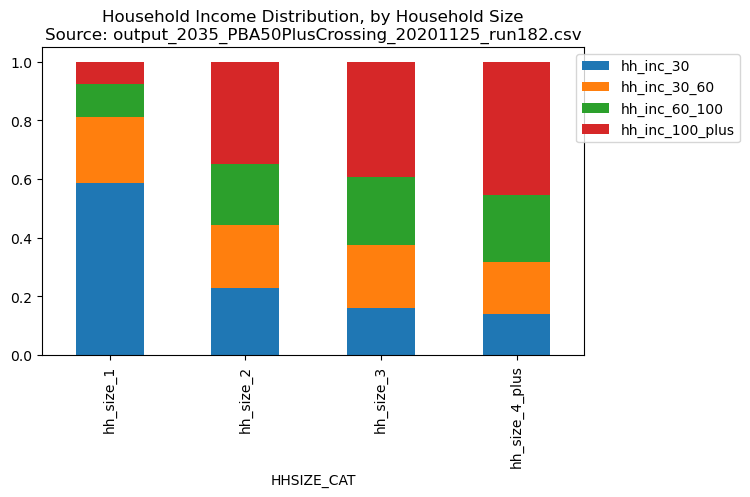

In [305]:
ax = summary_inc_by_size.stack().groupby(level='HHSIZE_CAT').apply(
    pct).unstack('HHINC_CAT').plot(kind='bar', figsize=[7, 4], stacked=True)
ax.legend(loc=1, bbox_to_anchor=(1.3, 1))
ax.set_title(
    'Household Income Distribution, by Household Size\nSource: output_2035_PBA50PlusCrossing_20201125_run182.csv')

In [308]:
summary_inc_by_size.to_excel('pba50_run182_2035_hh_by_inc_by_hhsize.xlsx')

# Check relative to targets

In [294]:
tazdata = pd.read_csv(
    '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Final Blueprint runs/Final Blueprint (s24)/BAUS v2.25 - FINAL VERSION/run182_taz_summaries_2035.csv')

tazdata.filter(regex='HIN').sum()

HHINCQ1     973831.0
HHINCQ2     724576.0
HHINCQ3     679340.0
HHINCQ4    1117465.0
dtype: float64

In [296]:
targets = pd.read_csv(
    '/Users/aolsen/Box/Modeling and Surveys/Urban Modeling/Bay Area UrbanSim/PBA50/Basemap/output_2035_PBA50PlusCrossing_20201125_run182/summary_TAZ.csv')
targets.filter(regex='hh_inc.+control')

,hh_inc_30_control,hh_inc_30_60_control,hh_inc_60_100_control,hh_inc_100_plus_control
0,22.0,10.0,3.0,13.0
1,63.0,32.0,15.0,29.0
2,133.0,74.0,25.0,50.0
3,93.0,51.0,22.0,43.0
4,329.0,141.0,75.0,118.0
...,...,...,...,...
1444,300.0,467.0,596.0,1383.0
1445,274.0,297.0,464.0,1025.0
1446,323.0,361.0,432.0,1097.0
1447,64.0,62.0,55.0,125.0


## Check totals

In [276]:
# 2,321

hh.shape[0] - targets.filter(regex='hh_inc.+con').sum().sum()

2321.0

## Check income groups, targets vs synthetic file

In [277]:
# difference targets and household file, with income 2000 bins. Not zero, but rounding errors still.

hh["HHINC_CAT"].value_counts().sort_values()-targets.filter(regex='hh_inc.+control').rename(columns=lambda x: x.replace('_control','')).sum().sort_values()

hh_inc_60_100      634.0
hh_inc_30_60       768.0
hh_inc_30          261.0
hh_inc_100_plus    335.0
dtype: float64

## Check size groups, targets vs synthetic file

In [292]:
# use the tazdata file instead - the targets file blends group quarter pop into household size 1
hh["HHSIZE_CAT"].value_counts().sort_values() - tazdata.filter(regex='hh_si').sum()

hh_size_1         3480.0
hh_size_2         2481.0
hh_size_3        -1141.0
hh_size_4_plus   -2498.0
dtype: float64